# Rejig mfbmCNN on ViaLactea coldens rejig

Use the mfbmCNN model (64px) model on ViaLactea coldens. 

Rejigged version.

Nans masked with a window

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import cv2
import pickle
import pandas as pd
import re
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import cv2
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import uniform_filter
from scipy.stats import mode
import scipy.misc

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
PPMAP_PATH = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'
MODEL_32_PATH = 'D:/Workshop/PhD/Models/model32px_large'
RESULTS_PATH = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_rejigged_fulltile/'

N_PIX = 32

In [3]:
model_32px = tf.keras.models.load_model(MODEL_32_PATH)
model_32px.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0     

In [4]:
progress_df = pd.read_csv(f'{RESULTS_PATH}progress.csv')
progress_df

,Direction,H,S,coords
0,l000,0.119728,2.487259,"[359.97972099949186, 0.040683222371426846]"
1,l002,0.396614,1.249077,"[2.1806678248157163, 0.04199591122993718]"
2,l004,0.448734,1.296370,"[4.422267619137547, -0.03956923833120953]"
3,l006,0.367312,0.832660,"[6.621406735872328, -0.04000965792996351]"
4,l008,0.457904,1.524660,"[8.82163708762842, -0.0396701575320798]"
5,l011,0.419663,0.932919,"[11.022578182449664, -0.0399307762963046]"
6,l013,0.463264,1.015461,"[13.222981615873511, -0.04029046793181044]"
7,l015,0.295701,0.828637,"[15.423059743318497, -0.04037669770199266]"
8,l017,0.398911,0.789092,"[17.62332152577781, -0.03967661139352237]"
9,l019,0.374025,0.987599,"[19.824940934740628, -0.03954968511030018]"


In [5]:
a = np.empty((N_PIX,N_PIX))
a[:] = np.nan
a = np.asarray([np.array(a).reshape(N_PIX, N_PIX, 1)])
default_values = model_32px.predict(a)[0]
default_values

array([0.9994058, 1.0947635], dtype=float32)

In [6]:
def HS_measurements(img, model, N_p):
    H_array = []
    S_array = []
    #img = np.nan_to_num(img)
    for y in tqdm(np.arange(np.shape(img)[1])):
        X = []
        for x in np.arange(np.shape(img)[0]):
            sub_field = img[int(x-N_p/2):int(x+N_p/2),int(y-N_p/2):int(y+N_p/2)]
            
            if np.shape(sub_field) == (N_p,N_p):
                
                sub_field = np.nan_to_num(sub_field)
                                
#                 k = int(sub_field.shape[0]/2)
#                 sub_field = sub_field.reshape(k,2,k,2).swapaxes(1,2).reshape(k,k,4).mean(axis=-1)
#                 sub_field[sub_field == 0] = np.nan
                
#                 sub_field = sub_field/np.nanmax(sub_field) * 255
#                 sub_field = np.uint8(sub_field)
#                 mask = np.uint8(np.isnan(sub_field))
#                 sub_field = cv2.inpaint(sub_field,mask,3,cv2.INPAINT_TELEA)
                                
                m_1_field = np.mean(sub_field)
                s_1_field = np.std(sub_field)
                m_2_field = 0
                s_2_field = 1/4

                sub_field = sub_field * s_2_field/s_1_field
                sub_field += (m_2_field-m_1_field*s_2_field/s_1_field)
                sub_field[np.where(sub_field>1.)] = 1.
                sub_field[np.where(sub_field<-1.)] = -1.
                sub_field = (sub_field-np.min(sub_field))/(np.max(sub_field)-np.min(sub_field))
                
                sub_field = np.array(sub_field).reshape(N_p, N_p, 1)
                X.append(sub_field)
                
        if len(X) != 0:
            X = np.asarray(X)
            preds = model.predict(X)
            H_array.append(preds[:,0])
            S_array.append(preds[:,1])
            
    H_array = np.asarray(H_array).T
    S_array = np.asarray(S_array).T
       
    return H_array,S_array

In [7]:
coords_list = []
H_list = []
S_list = []

for folder in os.listdir(PPMAP_PATH):
    #construct tile number from folder name
    
    direction = folder[1:4]
    #check whether the particular tile has already been calculated in progress.csv
    if not (progress_df['Direction']==f'l{direction}').any():
        print(f'l{direction}')
        #load in the fits file
        hdu = fits.open(f'{PPMAP_PATH}{folder}/l{direction}_cdens.fits')[0]
        #load in the WCS and image data
        wcs = WCS(hdu.header)
        image_array = hdu.data
                
        #plot tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(np.log10(image_array), origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/Inputs/{direction}.png')
        plt.close()
        
        #start the H and S measurements
        H_array, S_array = HS_measurements(image_array, model_32px, N_PIX)      
        np.savetxt(f'{RESULTS_PATH}H/raw_data/{direction}.txt',H_array)
        np.savetxt(f'{RESULTS_PATH}S/raw_data/{direction}.txt',S_array)
                           
        H_mod_array = np.where(H_array==mode(H_array)[0][0], 0, H_array)
        S_mod_array = np.where(S_array==mode(S_array)[0][0], 0, S_array)
    
        mask = H_mod_array.copy()
        mask[H_mod_array==0] = np.nan
        mask[H_mod_array!=0] = 1
        
        #plot raw H-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(H_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/H/raw_images/{direction}.png')
        plt.close()
        
        #plot raw S-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(S_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/S/raw_images/{direction}.png')
        plt.close()

        #Get average filter of H map and S map
        H_avg_array = uniform_filter(H_array, size=N_PIX*2, mode='mirror')*mask
        S_avg_array = uniform_filter(S_array, size=N_PIX*2, mode='mirror')*mask
        
        #plot avg H-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(H_avg_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/H/avg_images/{direction}.png')
        plt.close()
        
        #plot avg S-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(S_avg_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/S/avg_images/{direction}.png')
        plt.close()
        
        #save the avg data
        np.savetxt(f'{RESULTS_PATH}H/avg_data/{direction}.txt',H_avg_array)
        np.savetxt(f'{RESULTS_PATH}S/avg_data/{direction}.txt',S_avg_array)
        
        #prepare the image for getting overall H and S
        img = image_array/np.nanmax(image_array) * 255
        img = np.uint8(img)
        size = np.shape(img)
        mask = np.uint8(np.isnan(img))
        array_conv=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
        centre_coords = pixel_to_skycoord(size[0]/2,size[0]/2, wcs)

        m_1_field = np.mean(array_conv)
        s_1_field = np.std(array_conv)
        m_2_field = 0
        s_2_field = 1/4

        x = array_conv * s_2_field/s_1_field
        x += (m_2_field-m_1_field*s_2_field/s_1_field)
        x[np.where(x>1.)] = 1.
        x[np.where(x<-1.)] = -1.
        x = (x-np.min(x))/(np.max(x)-np.min(x))

        x = cv2.resize(x, (N_PIX,N_PIX))    
        x = x.reshape(1, N_PIX, N_PIX, 1)

        preds = model_32px.predict(x)[0]
        H=preds[0]
        S=preds[1]
        
        x = np.arange(0,size[0])
        y = np.arange(0,size[1])
        xx, yy = np.meshgrid(x, y)
        coords_grid = pixel_to_skycoord(xx,yy, wcs)
        coords = [centre_coords.l.degree, centre_coords.b.degree]
        
        data_cube = np.array([image_array,H_avg_array,S_avg_array,coords_grid.l.degree,coords_grid.b.degree])
        pickle_out = open(f'{RESULTS_PATH}DataCubes/l{direction}.pickle','wb')
        pickle.dump(data_cube,pickle_out)
        pickle_out.close()
        
        new_row = {'Direction':f'l{direction}',
                   'H':H,
                   'S':S,
                   'coords':coords}
        progress_df = progress_df.append(new_row,ignore_index=True)
        progress_df.to_csv(f'{RESULTS_PATH}progress.csv',index=False)

l072


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.17it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:38<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l074


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.12it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:27<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l077


  1%|▉                                                                               | 16/1440 [00:00<01:07, 21.19it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:50<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l079


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.09it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:48<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l081


  1%|▊                                                                               | 14/1440 [00:00<01:02, 22.81it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:33<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l083


  1%|▊                                                                               | 14/1440 [00:00<01:05, 21.61it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:32<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l085


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.17it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:34<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l088


  1%|▊                                                                               | 14/1440 [00:00<01:01, 23.16it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:35<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l090


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.81it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:28<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l092


  1%|▊                                                                               | 15/1440 [00:00<00:59, 24.10it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:43<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l094


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.45it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:30<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l096


  1%|▊                                                                               | 14/1440 [00:00<01:03, 22.28it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:30<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l099


  1%|▊                                                                               | 14/1440 [00:00<00:58, 24.35it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:35<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l101


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.51it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:28<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l103


  1%|▊                                                                               | 14/1440 [00:00<01:04, 21.98it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:35<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l105


  1%|▉                                                                               | 16/1440 [00:00<01:09, 20.58it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:30<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l107


  1%|▊                                                                               | 14/1440 [00:00<00:59, 24.17it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:37<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l110


  1%|▊                                                                               | 15/1440 [00:00<01:00, 23.62it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:31<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l112


  1%|▉                                                                               | 16/1440 [00:00<01:13, 19.38it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:36<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l114


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.21it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:37<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l116


  1%|▉                                                                               | 16/1440 [00:00<01:07, 20.96it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:31<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l118


  1%|▉                                                                               | 16/1440 [00:00<01:08, 20.94it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:30<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l121


  1%|▊                                                                               | 14/1440 [00:00<01:03, 22.45it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:36<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l123


  1%|▊                                                                               | 15/1440 [00:00<01:02, 22.92it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:35<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l125


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.81it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:38<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l127


  1%|▊                                                                               | 14/1440 [00:00<01:00, 23.67it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:29<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l129


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.25it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:31<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l132


  1%|▉                                                                               | 16/1440 [00:00<01:14, 19.09it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:33<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l136


  1%|▊                                                                               | 15/1440 [00:00<01:02, 22.93it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:30<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l138


  1%|▊                                                                               | 15/1440 [00:00<00:54, 25.97it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:31<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l140


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.13it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:31<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l143


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.72it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:40<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l145


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.36it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l147


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.83it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:33<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l149


  1%|▊                                                                               | 14/1440 [00:00<01:05, 21.86it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:58<00:00,  1.14it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l151


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.74it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:18<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l154


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.36it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l156


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.54it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:19<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l158


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.58it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l160


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.36it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l162


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.26it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l165


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.19it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:22<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l167


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.63it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:19<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l169


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.24it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:17<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l171


  1%|▊                                                                               | 14/1440 [00:00<00:58, 24.20it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:22<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l173


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.74it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:23<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l176


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.01it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:24<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l178


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.46it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:34<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l180


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.57it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l182


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.60it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:21<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l184


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.59it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:23<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l187


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.83it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:22<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l189


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.57it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:22<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l191


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.51it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:23<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l193


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.13it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:43<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l195


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.51it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l198


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.77it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:55<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l200


  1%|▊                                                                               | 15/1440 [00:00<00:58, 24.54it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:52<00:00,  1.05it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l202


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.42it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:16<00:00,  1.13it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l204


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.87it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:04<00:00,  1.14it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l206


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.39it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:29<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l209


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.33it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:13<00:00,  1.13it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l211


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.57it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:13<00:00,  1.13it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l213


  1%|▊                                                                               | 14/1440 [00:00<01:03, 22.38it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:22<00:00,  1.12it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l215


  1%|▊                                                                               | 14/1440 [00:00<01:01, 23.02it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:29<00:00,  1.12it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l217


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.45it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:28<00:00,  1.12it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l220


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.27it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:00<00:00,  1.14it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l222


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.75it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:06<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l224


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.81it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:25<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l226


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.15it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l228


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.61it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:56<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l231


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.24it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:58<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l233


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.64it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:51<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l235


  1%|▊                                                                               | 15/1440 [00:00<01:15, 19.00it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:56<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l237


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.09it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:53<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l239


  1%|▊                                                                               | 14/1440 [00:00<01:01, 23.19it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:00<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l242


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.90it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:57<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l244


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.46it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:31<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l246


  1%|▊                                                                               | 14/1440 [00:00<01:07, 21.12it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:54<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l248


  1%|▊                                                                               | 15/1440 [00:00<01:02, 22.92it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:49<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l250


  1%|▊                                                                               | 14/1440 [00:00<01:05, 21.88it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:48<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l253


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.12it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:46<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l255


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.23it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:46<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l257


  1%|▊                                                                               | 15/1440 [00:00<00:58, 24.51it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:55<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l259


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.66it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:52<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l261


  1%|▊                                                                               | 15/1440 [00:00<00:59, 23.90it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:48<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l264


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.16it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:43<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l266


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.36it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:43<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l268


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.74it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:51<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l270


  1%|▊                                                                               | 14/1440 [00:00<00:59, 23.82it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:43<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l272


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.46it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:48<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l275


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.84it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:42<00:00,  1.11it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l277


  1%|▊                                                                               | 14/1440 [00:00<01:04, 22.00it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:47<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l279


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.06it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:46<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l281


  1%|▊                                                                               | 14/1440 [00:00<00:59, 24.14it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:44<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l283


  1%|▊                                                                               | 15/1440 [00:00<00:58, 24.42it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:49<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l286


  1%|▊                                                                               | 15/1440 [00:00<00:54, 25.93it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:46<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l288


  1%|▊                                                                               | 15/1440 [00:00<00:54, 26.22it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:45<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l290


  1%|▊                                                                               | 15/1440 [00:00<00:54, 25.99it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:08<00:00,  1.14it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l292


  1%|▊                                                                               | 14/1440 [00:00<01:01, 23.04it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:18<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l294


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.53it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:21<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l297


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.72it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:20<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l299


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.64it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:22<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l301


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.97it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:21<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l303


  1%|▊                                                                               | 15/1440 [00:00<00:58, 24.49it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:24<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l305


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.69it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:24<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l308


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.87it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:19<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l310


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.88it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:18<00:00,  1.18it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l312


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.77it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:25<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l314


  1%|▊                                                                               | 15/1440 [00:00<00:53, 26.49it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:32<00:00,  1.17it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l316


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.79it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:50<00:00,  1.05it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l319


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.04it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:48<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l321


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.97it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:02<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l323


  1%|▊                                                                               | 15/1440 [00:00<01:01, 23.35it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:30<00:00,  1.07it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l325


  1%|▊                                                                               | 15/1440 [00:00<00:59, 23.76it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:30<00:00,  1.07it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l327


  1%|▊                                                                               | 15/1440 [00:00<01:00, 23.74it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:17<00:00,  1.08it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l330


  1%|▊                                                                               | 15/1440 [00:00<00:59, 23.99it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:56<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l332


  1%|▊                                                                               | 14/1440 [00:00<01:03, 22.53it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:09<00:00,  1.13it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l334


  1%|▊                                                                               | 15/1440 [00:00<00:55, 25.66it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:50<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l336


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.09it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:48<00:00,  1.10it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l338


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.05it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:01<00:00,  1.09it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l341


  1%|▉                                                                               | 16/1440 [00:00<01:08, 20.85it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:20<00:00,  1.12it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l343


  1%|▊                                                                               | 15/1440 [00:00<01:10, 20.14it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:46<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l345


  1%|▊                                                                               | 14/1440 [00:00<01:03, 22.60it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:46<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l347


  1%|▊                                                                               | 15/1440 [00:00<00:57, 24.57it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [20:44<00:00,  1.16it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l349


  1%|▊                                                                               | 15/1440 [00:00<00:56, 25.05it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [21:16<00:00,  1.13it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l352


  1%|▊                                                                               | 14/1440 [00:00<00:59, 23.93it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [22:47<00:00,  1.05it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l354


  1%|▊                                                                               | 15/1440 [00:00<01:00, 23.52it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [25:37<00:00,  1.07s/it]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l356


  1%|▉                                                                               | 16/1440 [00:01<01:55, 12.33it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [23:20<00:00,  1.03it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l358


  1%|▊                                                                               | 15/1440 [00:00<01:01, 22.99it/s]C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [23:15<00:00,  1.03it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


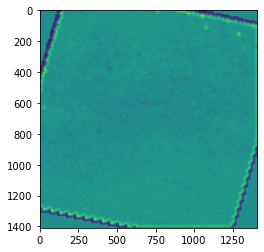

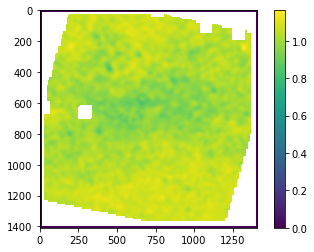

In [26]:
MASK_PATH = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_rejigged_fulltile/'
for folder in os.listdir(PPMAP_PATH):
    direction = folder[1:4]
    H_raw = np.loadtxt(f'{RESULTS_PATH}H/raw_data/{direction}.txt')
    H_mod_array = np.loadtxt(f'{MASK_PATH}H/avg_data/{direction}.txt')
    H_mod_array = np.nan_to_num(H_mod_array)
    
    mask = H_mod_array.copy()
    mask[H_mod_array==0] = np.nan
    mask[H_mod_array!=0] = 1
    
    mask = np.pad(mask, ((16,16),(16,16)), 'constant')
    
    H_avg_array = uniform_filter(H_raw, size=N_PIX, mode='mirror')*mask
    
    plt.figure()
    plt.imshow(H_raw)
    plt.show()
    
    plt.figure()
    plt.imshow(H_avg_array)
    plt.colorbar()
    plt.show()
    
    break

In [ ]:
plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(H_array, origin = 'lower')
plt.colorbar()
plt.title(f'l{direction}')
#plt.savefig('D:/Workshop/PhD\Meetings/20220428/raw_H_02.png')
plt.show()

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(H_avg_array, origin = 'lower')
plt.colorbar()
#plt.savefig('D:/Workshop/PhD/Meetings/20220428/avg_H_02.png')
plt.show()

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(mask, origin = 'lower')
plt.colorbar()
#plt.savefig('D:/Workshop/PhD/Meetings/20220428/avg_H_02.png')
plt.show()

In [19]:
mode(H_array, axis=None)[0][0]

0.8101196

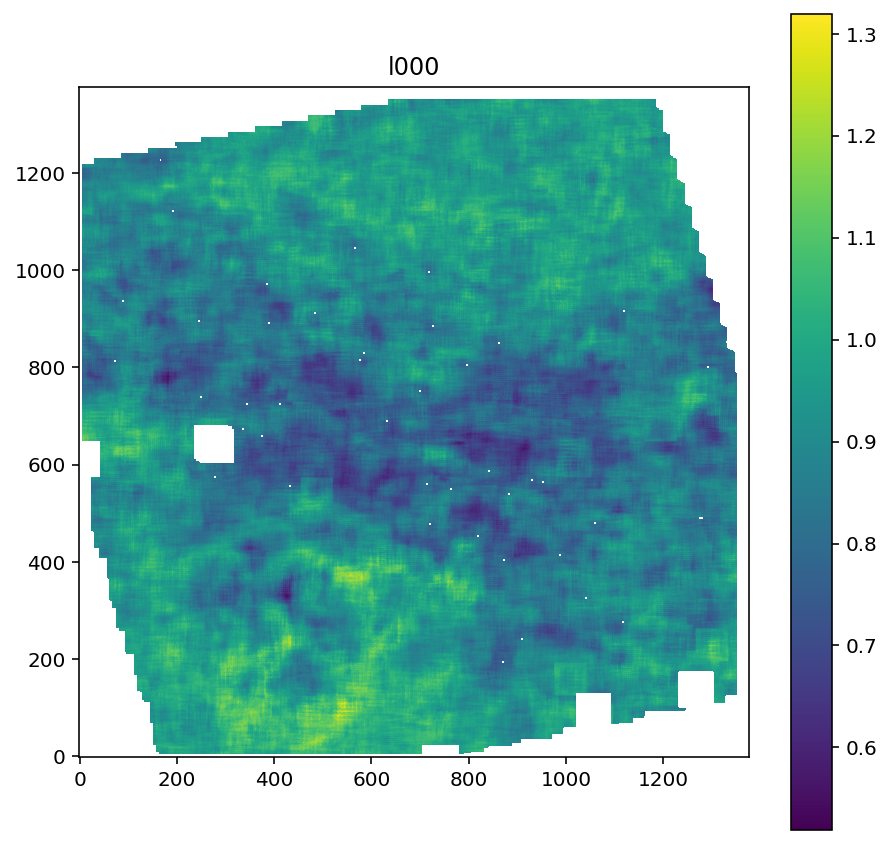

In [14]:
mask_test = H_array.copy()
mask_test[mask_test==0] = np.nan

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(mask_test, origin = 'lower')
plt.colorbar()
plt.title(f'l{direction}')
#plt.savefig('D:/Workshop/PhD\Meetings/20220428/raw_H_02.png')
plt.show()


In [66]:
H_array<=0.81012

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

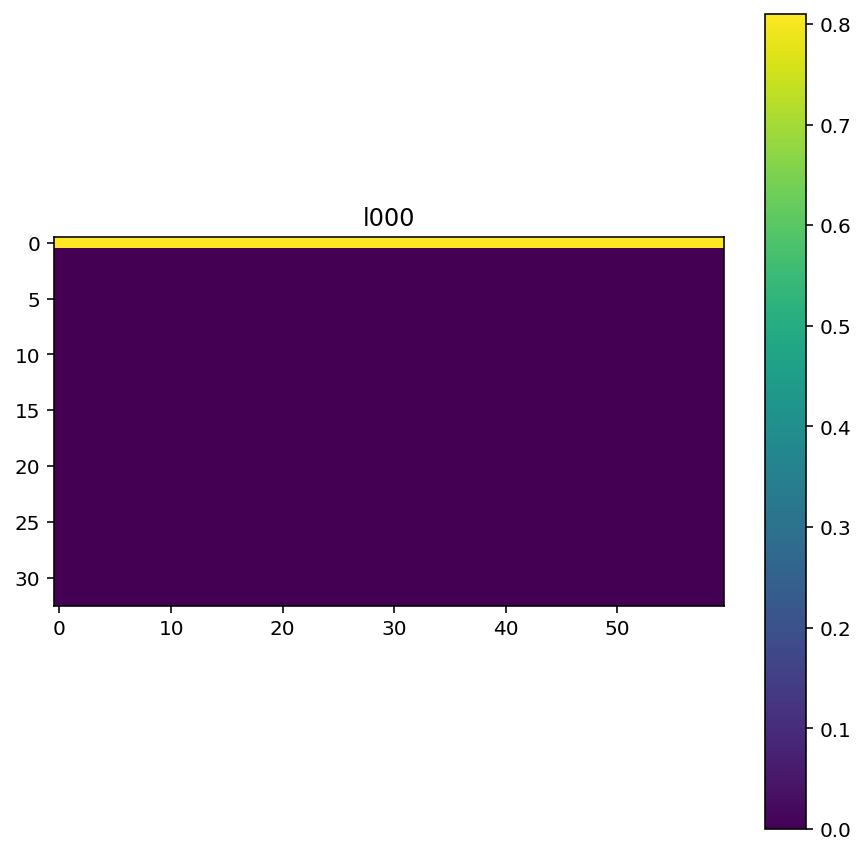

[[0.81011945 0.81011945 0.81011945 ... 0.81011945 0.81011945 0.81011945]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [61]:
plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(np.where(H_array!=0.8101196, H_array, 0)[1407:,40:100])#, origin = 'lower')
plt.colorbar()
plt.title(f'l{direction}')
#plt.savefig('D:/Workshop/PhD\Meetings/20220428/raw_H_02.png')
plt.show()

print(np.where(H_array!=0.8101196, H_array, 0)[1407:,40:100])

C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\matplotlib\axes\_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\matplotlib\axes\_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

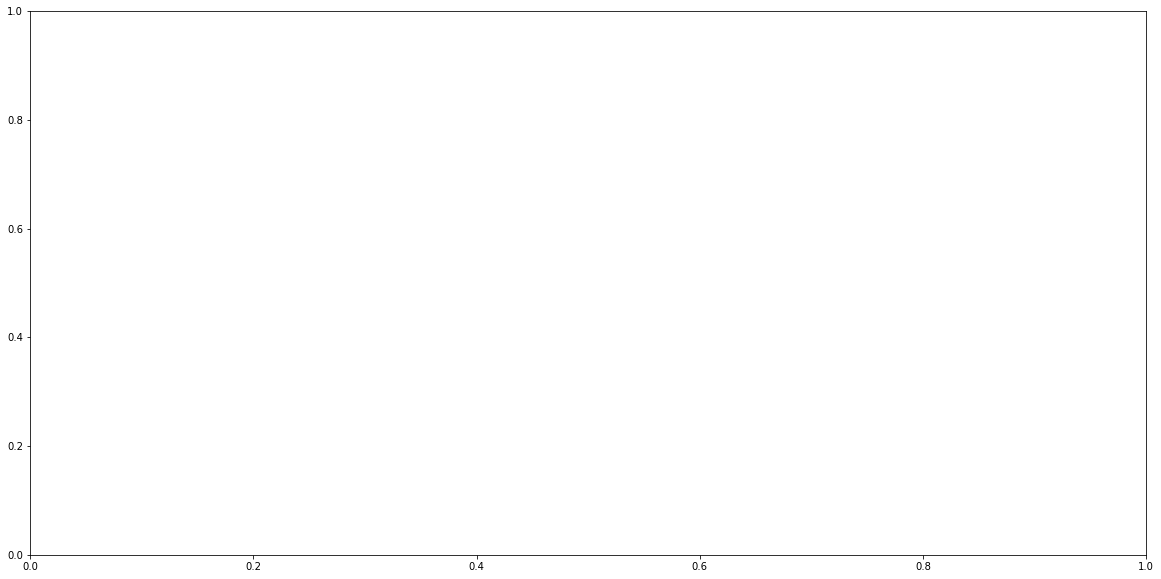

In [9]:
plt.figure(figsize=(20,10))
plt.hist(H_array_nans.flatten(), bins=100, density = True)
plt.xlabel('H')
plt.savefig('D:/Workshop/PhD/Meetings/20220428/mask_H_02_hist.png')
plt.show()